# Построение первой модели. Линейная регрессия

## Краткое описание:
Пытался провести анализ всех features из dataset'a. Анализировал с помощью описания данных, value_counts, визуализации. Графики не сохранял, но можно посмотреть ниже, чем в целом пользовался. Часть данных выкинул, большую часть переписал. Добавил вместо некоторых фич свои, созданные из удаленных. Большинство категориальных признаков переведены в наборы бинарных.
Обучение делал вначале на части выборки, на отложенной выборке провел анализ результатов, посчитал некоторые метрики. Визуализация приведена.
Итоговое обучение построено на полной выборке, результаты загружены на kaggle.

Это первый опыт работы. Столкнулся с ошибкой "выброса" на одной из строк - предсказание получалось на 15 порядков больше, не понял как с этим бороться и просто заменил строку на другую. Наверное, что то с матрицей и сильной корреляцией величин. Пока не умею с этим работать.

В целом попытался выполнить "необязательное задание"

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import numpy as np
import pandas as pd
import seaborn as sns

Чтение данных, запись данных для визуализации (чтобы не искажать исходные)

In [2]:
# s_s = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
for_visual = pd.read_csv('train.csv')

In [3]:
# запись вектора решений
y_train = train.SalePrice
train.drop('SalePrice', axis=1, inplace=True)

In [4]:
train['is_test'] = 0
test['is_test'] = 1

In [5]:
# объединение матриц
train = pd.concat([train, test])

In [6]:
'''удаляем 'лишние' столбцы'''
train.drop( ['Id', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
          'Exterior2nd', 'Condition2', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2','BsmtUnfSF', 'LowQualFinSF',
          'GrLivArea', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
          'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'Street'], axis=1, inplace = True)


In [7]:
'''создаем новый параметр умножением состояния на качество материалов'''
train.OverallQual = train.OverallCond * train.OverallQual
train.drop('OverallCond', axis=1, inplace = True)

In [8]:
'''переводим состояние и качество фасада в int и создаем на основе новый параметр'''
train.ExterCond = train.ExterCond.replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po' ], value=[5, 4, 2, 1, 0])
train.ExterQual = train.ExterQual.replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po' ], value=[5, 4, 2, 1, 0])
train.ExterQual = train.ExterCond * train.ExterQual
train.drop('ExterCond', axis=1, inplace = True)


In [9]:
'''переводим наличие ремонта в булеву переменную'''
train['IsRemod'] = train.apply(lambda row: row['YearBuilt'] - row['YearRemodAdd'] < 0, axis = 1)
train.drop('YearRemodAdd', axis=1, inplace = True)


In [10]:
'''переводим год постройки в возраст дома'''
train.YearBuilt = 2010 - train.YearBuilt

In [11]:
'''заполняем пропуски'''
train.MasVnrType = train.MasVnrType.fillna('None')
train.BsmtQual = train.BsmtQual.fillna('Po')
train.BsmtCond = train.BsmtCond.fillna('Po')
train.Electrical = train.Electrical.fillna('SBrkr')

In [12]:
'''переводим состояние и качество фасада в int и создаем на основе новый параметр'''
train.BsmtCond = train.BsmtCond.replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po' ], value=[5, 4, 2, 1, 0])
train.BsmtQual = train.BsmtQual.replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po' ], value=[5, 4, 2, 1, 0])
train.BsmtQual = train.BsmtQual * train.BsmtCond
train.drop('BsmtCond', axis=1, inplace = True)

In [13]:
'''наличие кондиционера - 1/0'''
train.CentralAir = train.CentralAir.replace(to_replace=['Y', 'N'], value = [1, 0])

In [14]:
'''заменяем значения в качестве отопления и в других столбцах'''
train.HeatingQC = train.HeatingQC.replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po' ], value=[5, 4, 2, 1, 0])
train.KitchenQual = train.KitchenQual.replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po' ], value=[5, 4, 2, 1, 0])
train.FireplaceQu.fillna('TA')
train.FireplaceQu = train.FireplaceQu.replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po' ], value=[7, 4, 2, 1, 0])
train.Fireplaces = train.Fireplaces * train.FireplaceQu
train.drop('FireplaceQu', axis=1, inplace = True)

In [15]:
'''длительность продажи'''
train['duration'] = (2010 - train.YrSold)

In [16]:
'''заполняем пропуски'''
train.LotFrontage = train.LotFrontage.fillna(0)
train.MasVnrArea = train.MasVnrArea.fillna(0)
train.BsmtExposure = train.BsmtExposure.fillna('No')
train.Fireplaces = train.Fireplaces.fillna(0)
train.BsmtFullBath = train.BsmtFullBath.fillna(0)
train.GarageArea = train.GarageArea.fillna(0)
train.KitchenQual = train.KitchenQual.fillna(0)
train.MSZoning = train.MSZoning.fillna('RL')
train.SaleType = train.SaleType.fillna('WD')
train.TotalBsmtSF = train.TotalBsmtSF.fillna(0)
train.BsmtHalfBath = train.BsmtHalfBath.fillna(0)


In [17]:
'''форма здания: стандартная/не стандартная'''
train['Shape'] = train.apply(lambda x: x['LotShape'] != 'Reg', axis = 1)
train.drop('LotShape', axis=1, inplace = True)

In [18]:
'''переводим категориальные признаки'''
df_dummies = pd.get_dummies(train, columns=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 
                                            'BldgType', 'HouseStyle', 'MasVnrType', 'Foundation', 
                                            'BsmtExposure', 'Heating', 'Electrical', 'PavedDrive',
                                            'SaleType', 'SaleCondition'])

In [19]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 145 entries, LotFrontage to SaleCondition_Partial
dtypes: bool(2), float64(8), int64(24), uint8(111)
memory usage: 1.0 MB


Такими графиками пытался оценить фичи и их влияние

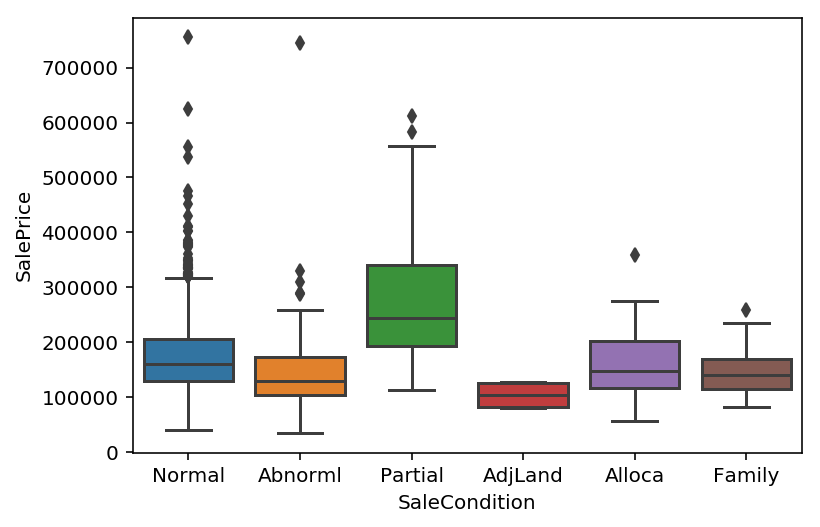

In [20]:
sns.boxplot(x="SaleCondition", y="SalePrice", 
            data=for_visual)

In [21]:
# plt.plot(for_visual['LotArea'], train['SalePrice'], 'bo')

Разбиваем на train и test обратно

In [22]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

## Нормировка значений

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
X_train.shape

(1460, 144)

In [25]:
scaler = StandardScaler()

In [26]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
columns = X_train.columns

In [28]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns)

In [29]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns)

## Выделение отложенной выборки

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_test_scaled.loc[1358] = X_test_scaled.loc[1348]

In [32]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3)

## Предсказание на выборке 0.8

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
lr = LinearRegression()

In [35]:
lr.fit(X_train_fin, y_train_fin)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
y_pred_val = lr.predict(X_val)

In [48]:
y_pred_val[y_pred_val>10000000]

array([6.34491484e+13])

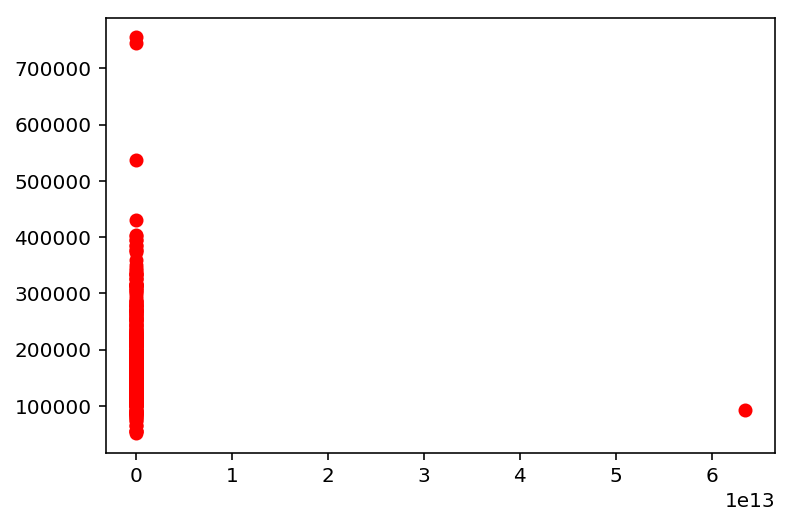

In [37]:
plt.plot(y_pred_val, y_val, 'ro')

In [38]:
np.mean((y_pred_val-y_val)**2)

9.19131146790116e+24

In [39]:
(np.mean((y_pred_val-y_val)**2))**(1/2)

3031717577199.624

## Финальное предсказание

In [40]:
# X_test_scaled.loc[1358] = X_test_scaled.loc[1348]

In [41]:
lr_f= LinearRegression()

In [42]:
lr_f.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
y_pred = lr_f.predict(X_test_scaled)

## Создание файла

In [44]:
df_pred = pd.DataFrame(for_visual.Id, columns = ['Id'])

In [45]:
df_pred['SalePrice'] = y_pred

ValueError: Length of values does not match length of index

In [ ]:
df_pred = df_pred.set_index('Id')

In [ ]:
df_pred.to_csv('submission.csv')